### 1. Data analysis.

In [1]:
#download the data
!wget https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip
!unzip BoolQ.zip

--2021-09-05 06:13:59--  https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4118001 (3.9M) [application/zip]
Saving to: ‘BoolQ.zip’

BoolQ.zip           100%[===================>]   3.93M  8.09MB/s    in 0.5s    

2021-09-05 06:14:00 (8.09 MB/s) - ‘BoolQ.zip’ saved [4118001/4118001]

Archive:  BoolQ.zip
   creating: BoolQ/
  inflating: BoolQ/train.jsonl       
  inflating: BoolQ/test.jsonl        
  inflating: BoolQ/val.jsonl         


In [2]:
import pandas as pd
import numpy as np
import torch
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using:', device)

Using: cuda


In [4]:
# Load training and validation datasets into a pandas dataframe
train_df = pd.read_json("./BoolQ/train.jsonl", orient='records', lines=True)
val_df = pd.read_json("./BoolQ/val.jsonl", orient='records', lines=True)

In [5]:
train_df.sample(5)

,question,passage,idx,label
2191,is it illegal to flash lights to warn of police,"Headlight flashing -- In the United States, al...",2191,False
968,behind enemy lines was it based on a true story,Scott O'Grady -- Scott Francis O'Grady (born O...,968,True
891,is a star is born with lady gaga a remake,A Star Is Born (2018 film) -- A Star Is Born i...,891,True
5616,has anyone ever won the moment of truth,The Moment of Truth (U.S. game show) -- Howeve...,5616,True
7924,does the bride have to wear a white dress,Wedding dress -- A wedding dress or wedding go...,7924,False


In [6]:
val_df.sample(5)

,question,passage,idx,label
1295,do playstation 2 games play on playstation 4,List of PlayStation 2 games for PlayStation 4 ...,1295,True
2883,does the us constitution allow states to secede,Secession in the United States -- The Constitu...,2883,False
2368,can you play gameboy games on a ds lite,Nintendo DS Lite -- The Nintendo DS Lite is co...,2368,True
2474,is the tower of terror in magic kingdom,The Twilight Zone Tower of Terror -- The Twili...,2474,False
1412,has brazil ever won the world cup in europe,Brazil at the FIFA World Cup -- Brazil is the ...,1412,True


Basic statistics (example number, class distribution, mean sentence length, number of unique words, etc.):

In [7]:
#number of sentences
print('Number of training data: {:,}\n'.format(train_df.shape[0]))
print('Number of validation data: {:,}\n'.format(val_df.shape[0]))

Number of training data: 9,427

Number of validation data: 3,270



In [8]:
print('Class distribution of training data:\n', (train_df.label.value_counts() / train_df.shape[0]).to_dict())
print('Class distribution of validation data:\n', (val_df.label.value_counts() / val_df.shape[0]).to_dict())

Class distribution of training data:
 {True: 0.6231038506417736, False: 0.37689614935822635}
Class distribution of validation data:
 {True: 0.6217125382262997, False: 0.3782874617737003}


So, the majority-class baseline accuracy for validation data is 62.2% (only 'yes' answers).

Text(0.5, 1.0, 'Val')

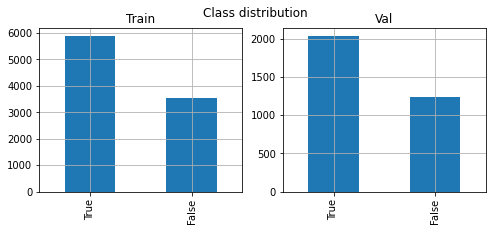

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
fig.suptitle('Class distribution')

plt.subplot(1, 2, 1)
train_df.label.value_counts().plot(kind='bar')
plt.grid()
plt.title('Train')

plt.subplot(1, 2, 2)
val_df.label.value_counts().plot(kind='bar')
plt.grid()
plt.title('Val')

In [10]:
print('Mean sentence length (in words) of training data:', (train_df.question + ' ' + train_df.passage).apply(lambda x: len(x.split())).mean())
print('Mean sentence length (in words) of validation data:', (val_df.question + ' ' + val_df.passage).apply(lambda x: len(x.split())).mean())

Mean sentence length (in words) of training data: 106.26307414872176
Mean sentence length (in words) of validation data: 105.11192660550459


In [11]:
print('Mean sentence length (in symbols) of training data:', (train_df.question + ' ' + train_df.passage).apply(lambda x: len(x)).mean())
print('Mean sentence length (in symbols) of validation data:', (val_df.question + ' ' + val_df.passage).apply(lambda x: len(x)).mean())

Mean sentence length (in symbols) of training data: 635.1599660549485
Mean sentence length (in symbols) of validation data: 627.5125382262997


In [12]:
#tokenize function
def letters_digits_only(text):
    prepare_text = re.sub('[^a-z0-9 ]', ' ', text.lower())
    prepare_text = re.sub('[ ]{2,}', ' ', prepare_text).strip()
    tokens = [token for token in prepare_text.split()]
    return tokens

In [13]:
#concatenate questions and passages and tokenize them
train_df['qp_tokenized'] = (train_df.question + ' ' + train_df.passage).map(letters_digits_only)
val_df['qp_tokenized'] = (val_df.question + ' ' + val_df.passage).map(letters_digits_only)

train_df['qp_tokenized'].head(5)

0    [do, iran, and, afghanistan, speak, the, same,...
1    [do, good, samaritan, laws, protect, those, wh...
2    [is, windows, movie, maker, part, of, windows,...
3    [is, confectionary, sugar, the, same, as, powd...
4    [is, elder, scrolls, online, the, same, as, sk...
Name: qp_tokenized, dtype: object

In [14]:
#unique words
train_unique_words = set()
val_unique_words = set()

for s in train_df.qp_tokenized:
    train_unique_words |= set(s)

for s in val_df.qp_tokenized:
    val_unique_words |= set(s)

print('Number of unique words in training data:', len(train_unique_words))
print('Number of unique words in validation data:', len(val_unique_words))

Number of unique words in training data: 42022
Number of unique words in validation data: 25004


### 2. Pretrained embeddings as features for classifier.

* 2.1. Data vectorizing with pre-trained word2vec embeddings (GoogleNews vectors).

In [15]:
#download GoogleNews
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d GoogleNews-vectors-negative300.bin.gz

--2021-09-05 06:15:04--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.87.238
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.87.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  46.7MB/s    in 37s     

2021-09-05 06:15:41 (42.7 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [16]:
from gensim import models

word2vec = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [17]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = word2vec.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.word2vec[word] for word in words if word in self.word2vec]
                                 or [np.zeros(self.dim)], axis=0) for words in X])

In [18]:
vectorizer = MeanEmbeddingVectorizer(word2vec)

In [19]:
#vectorize the data
train_df_vec = vectorizer.transform(train_df.qp_tokenized.values)
val_df_vec = vectorizer.transform(val_df.qp_tokenized.values)

* 2.2. Use pretrained embeddings as features to a classifier. Train SVM, Linear Regression or any other classification model. Describe and analyze your results (use accuracy metric and data from val.jsonl for evaluation of your results).

In [5]:
answers_train = train_df.label.values.astype(int)
answers_val = val_df.label.values.astype(int)

questions_train = train_df.question.values
passages_train = train_df.passage.values

questions_val = val_df.question.values
passages_val = val_df.passage.values

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [21]:
#SVM
clf = SVC()
clf.fit(train_df_vec, answers_train)
answers_val_pred = clf.predict(val_df_vec)
score = accuracy_score(answers_val_pred, answers_val)
print('SVM accuracy:', score)

SVM accuracy: 0.6406727828746177


In [22]:
#Data scaling
scaler = StandardScaler()

scaled_train_df_vec = scaler.fit_transform(train_df_vec)
scaled_val_df_vec = scaler.fit_transform(val_df_vec)

In [23]:
#SVM on scaled data
clf = SVC()
clf.fit(scaled_train_df_vec, answers_train)
answers_val_pred = clf.predict(scaled_val_df_vec)
score = accuracy_score(answers_val_pred, answers_val)
print('SVM accuracy with scaling:', score)

SVM accuracy with scaling: 0.6611620795107034


In [24]:
#Logistic Regression
clf = LogisticRegression()
clf.fit(train_df_vec, answers_train)
answers_val_pred = clf.predict(val_df_vec)
score = accuracy_score(answers_val_pred, answers_val)
print('Logistic Regression accuracy:', score)

Logistic Regression accuracy: 0.6321100917431193


In [25]:
#Logistic Regression on scaled data
clf = LogisticRegression()
clf.fit(scaled_train_df_vec, answers_train)
answers_val_pred = clf.predict(scaled_val_df_vec)
score = accuracy_score(answers_val_pred, answers_val)
print('Logistic Regression accuracy with scaling:', score)

Logistic Regression accuracy with scaling: 0.6223241590214067


SVM and Linear Regression have slightly better accuracy then the baseline (but not sufficiently different in most cases).

* 2.3. Data vectorizing with BERT embeddings.

In [26]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 34.7 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 895 kB 58.1 MB/s 
     |████████████████████████████████| 636 kB 31.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
def get_sentence_embedding(questions, passages, model, tokenizer, max_length):
    embeddings = []
    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first", return_tensors='pt')
        input_ids = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        with torch.no_grad():
            last_hidden_states = model(input_ids, attention_mask=attention_mask)
        sentence_embedding = last_hidden_states[0]
        embeddings.append(sentence_embedding[:, 0, :].detach().cpu().numpy())

    return embeddings

In [30]:
model.to(device)

max_length = 256 #I use 256 for fare results with the 3rd chapter. With bigger max_length my google colab is out of memory
train_bert_embeddings = get_sentence_embedding(questions_train, passages_train, model=model, tokenizer=tokenizer, max_length=max_length)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [31]:
val_bert_embeddings = get_sentence_embedding(questions_val, passages_val, model=model, tokenizer=tokenizer, max_length=max_length)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


* 2.4. Similarly to 2.1, train SVM, Linear Regression or any other classification model using BERT embeddings as features for a classifier. Describe and analyze your results (use accuracy metric and data from val.jsonl for evaluation of your results).

In [32]:
train_bert_embeddings[0].shape

(1, 768)

In [33]:
train_bert_embeddings_flattened = [x.flatten() for x in train_bert_embeddings]
val_bert_embeddings_flattened = [x.flatten() for x in val_bert_embeddings]

In [34]:
train_bert_embeddings_flattened[0].shape

(768,)

In [35]:
#SVM
clf = SVC()
clf.fit(train_bert_embeddings_flattened, answers_train)
answers_val_pred = clf.predict(val_bert_embeddings_flattened)
score = accuracy_score(answers_val_pred, answers_val)
print('SVM accuracy:', score)

SVM accuracy: 0.6293577981651376


In [36]:
#Logistic Regression
clf = LogisticRegression()
clf.fit(train_bert_embeddings_flattened, answers_train)
answers_val_pred = clf.predict(val_bert_embeddings_flattened)
score = accuracy_score(answers_val_pred, answers_val)
print('Logistic Regression accuracy:', score)

Logistic Regression accuracy: 0.6449541284403669


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


SVM and Linear Regression with BERT embeddings also have slightly better accuracy then the majority-class baseline and it is almost the same as with word2vec embeddings.

### 3. Fine-tune BERT

* 3.1. Split the data from `train.jsonl` into train and dev (dev_size = 10%) . Tokenize and format the data (do not forget about the [SEP] token).

In [37]:
max_len = 0
for question, passage in zip(questions_train, passages_train):
    input_ids = tokenizer.encode(question, passage)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (971 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  971


The max sentence length is 971. It is longer than 512 (specified max sequence length for BERT). But I can't use 512 due to the google colab out of memory error. So I will use 256.

In [8]:
max_length = 256

In [9]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for question, passage in zip(questions_train, passages_train):
    encoded_data = tokenizer.encode_plus(question, passage,
                                         add_special_tokens = True,
                                         max_length=max_length,
                                         pad_to_max_length=True, 
                                         truncation_strategy="longest_first",
                                         return_attention_mask=True,
                                         return_tensors='pt')
       
    input_ids.append(encoded_data['input_ids'])
    attention_masks.append(encoded_data['attention_mask'])

# Convert the lists into tensors.
input_ids_train = torch.cat(input_ids, dim=0)
attention_masks_train = torch.cat(attention_masks, dim=0)
labels_train = torch.tensor(answers_train)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [10]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [11]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)

In [12]:
# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [13]:
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

8,484 training samples
  943 validation samples


* 3.2. Initialize the model, optimizer and learning rate scheduler. Explain your choice of the parameters.

In [14]:
#For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 24

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(train_dataset,
                              sampler = RandomSampler(train_dataset),
                              batch_size = batch_size)

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(val_dataset,
                                   sampler = SequentialSampler(val_dataset),
                                   batch_size = batch_size)

In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# The answers on the questions with given passages are yes or no. 
# So, we have 2 classes and we need to classify given embeddings.
# So, I will use BertForSequenceClassification.
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

I will use Adam optimizer (standard for BERT fine-tuning) with small learning rate: 1e-5. It is better than default 5e-5 and other recommended be BERT authors 3e-5, 2e-5. Also BERT authors recommend to choose number of trainings epochs between 2 and 4, but I'll use 5 epochs. Small learning rate and longer training give better result.
In the paper https://arxiv.org/pdf/1905.10044.pdf we have similar approach.

In [16]:

optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [17]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

* 3.3. Training loop for BERT fine-tuning (don't forget about evaluation on dev set created in 3.1). 

**Note:** I follow recommended tutorial for fine-tuning BERT: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [18]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [19]:
import random
# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#training and validation loss, validation accuracy, timings
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    # Put the model into training mode
    model.train()

    for i, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if i % 40 == 0 and not i == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(i, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear previously calculated gradients
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                             )
        loss, logits = output[0], output[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode
    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss, logits = output[0], output[1]
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    354.    Elapsed: 0:01:24.
  Batch    80  of    354.    Elapsed: 0:02:47.
  Batch   120  of    354.    Elapsed: 0:04:10.
  Batch   160  of    354.    Elapsed: 0:05:34.
  Batch   200  of    354.    Elapsed: 0:06:57.
  Batch   240  of    354.    Elapsed: 0:08:20.
  Batch   280  of    354.    Elapsed: 0:09:43.
  Batch   320  of    354.    Elapsed: 0:11:06.

  Average training loss: 0.65
  Training epcoh took: 0:12:16

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.63
  Validation took: 0:00:30

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    354.    Elapsed: 0:01:23.
  Batch    80  of    354.    Elapsed: 0:02:46.
  Batch   120  of    354.    Elapsed: 0:04:10.
  Batch   160  of    354.    Elapsed: 0:05:33.
  Batch   200  of    354.    Elapsed: 0:06:56.
  Batch   240  of    354.    Elapsed: 0:08:20.
  Batch   280  of    354.    Elapsed: 0:09:43.
  Batch   320  of    354.    Elapsed: 0:11:07.

  Averag

* 3.4. Make predictions for the test data (from `val.jsonl`),  and analyze the results (use accuracy metric for scoring).

In [20]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for question, passage in zip(questions_val, passages_val):
    encoded_data = tokenizer.encode_plus(question, passage,
                                         add_special_tokens = True,
                                         max_length=max_length,
                                         pad_to_max_length=True, 
                                         truncation_strategy="longest_first",
                                         return_attention_mask=True,
                                         return_tensors='pt')
       
    input_ids.append(encoded_data['input_ids'])
    attention_masks.append(encoded_data['attention_mask'])

# Convert the lists into tensors.
input_ids_val = torch.cat(input_ids, dim=0)
attention_masks_val = torch.cat(attention_masks, dim=0)
labels_val = torch.tensor(answers_val)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [21]:
batch_size = 24

test_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)
test_dataloader = DataLoader(test_dataset,
                             sampler = SequentialSampler(test_dataset),
                             batch_size = batch_size)

In [22]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,270 test sentences...
    DONE.


In [23]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [28]:
print(accuracy_score(flat_predictions, flat_true_labels))

0.7030581039755351


We get a good accuracy - 70.3% - after simple BERT fine-tuning. It's a good result comparing to majority-class baseline and base BERT.  

### 4. Summary & results analysis
* 4.1. Compare the results of all the tested models and try to interpret them.

The majority-class baseline accuracy for validation data is 62.2%.

Classical linear classifiers give us slightly better results:
* 64.1% on SVM with word2vec embeddings;
* 63.2% on Logistic Regression with word2vec embeddings;
* 66.1% on SVM with scaled word2vec embeddings;
* 62.2% on Logistic Regression with scaled word2vec embeddings;
* 62.9% on SVM with BERT embeddings;
* 64.5% on Logistic Regression with BERT embeddings.

I think that there was a correlation between the number of times question words occurred in the passage, but this correlation was not strong enough to build an effective classifier.

Fine-tuned BERT neural model give us the best result: 70.3%. Attention mechanism is what we need. Also, I try to use lr=5e-5, epochs=3 and batch_size=16 for fine-tuning and this parameters don't give me similar accuracy (the accuracy was about 63%). So, choosing parameters is a key to get a good accuracy for predictions.

In [ ]:
torch.save(model.state_dict(), 'qa_bert_model.pt')